#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Ход исследования:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Импортируем библиотеки, объявим константы

In [1]:
!pip install --upgrade scikit-learn -q

In [2]:
!pip install --upgrade lightgbm -q

In [3]:
!pip install --upgrade catboost -q

In [4]:
!pip install --upgrade prophet -q

In [5]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import(
    train_test_split, RandomizedSearchCV, 
    cross_validate, TimeSeriesSplit)
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from catboost import CatBoostRegressor
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

In [6]:
RANDOM_STATE = 42

In [7]:
warnings.filterwarnings('ignore')

Загрузим данные, переведем даты в соответствующий тип данных, сделаем столбец с датами индексом, отсортируем по возрастанию, проведем ресемплинг по одному часу, выведем первые строки таблицы и общую информацию

In [8]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
display(data.head(5))
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные загрузились и преобразовались корректно, получили записи с первого марта 2018 по тридцать первое августа 2018 года, всего 4416 записей, пропусков среди них нет

## Анализ

Выведем график  зависимости заказов от времени, а также скользящие среднее и стандартное отклонение

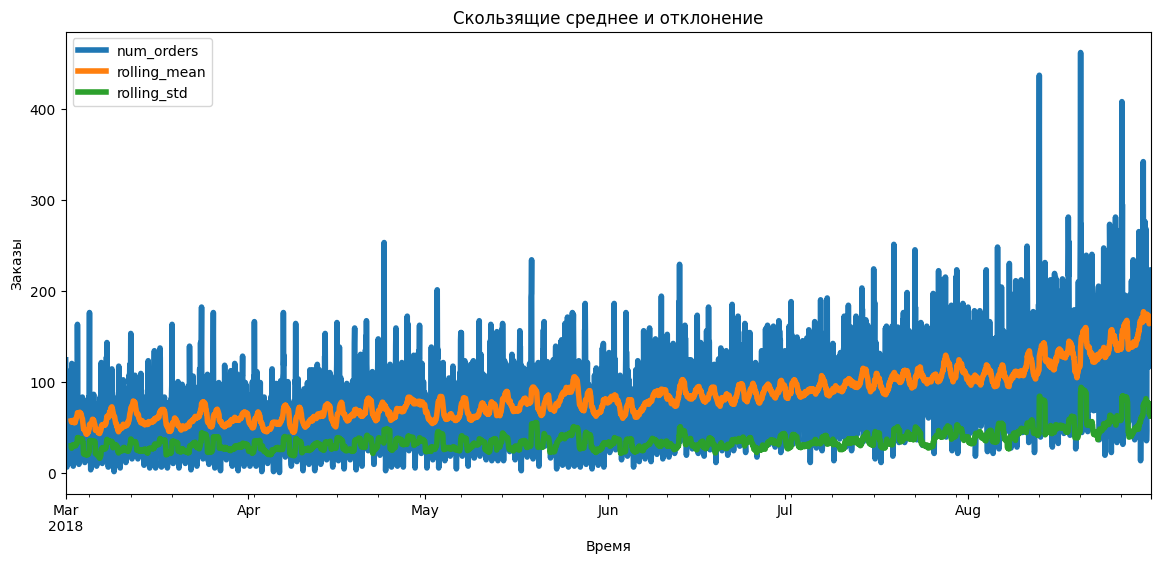

In [9]:
data_rolling = data
data['rolling_mean'] = data['num_orders'].rolling(24).mean() 
data['rolling_std'] = data['num_orders'].rolling(24).std()
data.plot(
    figsize=(14,6), linewidth=4, title='Скользящие среднее и отклонение', 
    xlabel='Время', ylabel='Заказы'
);
data = data.drop(columns=['rolling_mean', 'rolling_std'])

Видно небольшое увеличение тенденции и выбросы ближе к концу наблюдений. Чтобы однозначно судить о статичности временного ряда, проведем тест Дики-Фуллера и возьмем допустимым p-value не больше 0,05

In [10]:
result = adfuller(data)
print('p-value =', result[1])

p-value = 0.028940051402613094


p-value в пределах нормы, значит временной ряд можно считать статическим и делать на нем прогнозы.

Рассмотрим подробнее тренд, а также сезонность в месяцах, неделях и днях, найдём остатки

In [11]:
decomposed = seasonal_decompose(data)

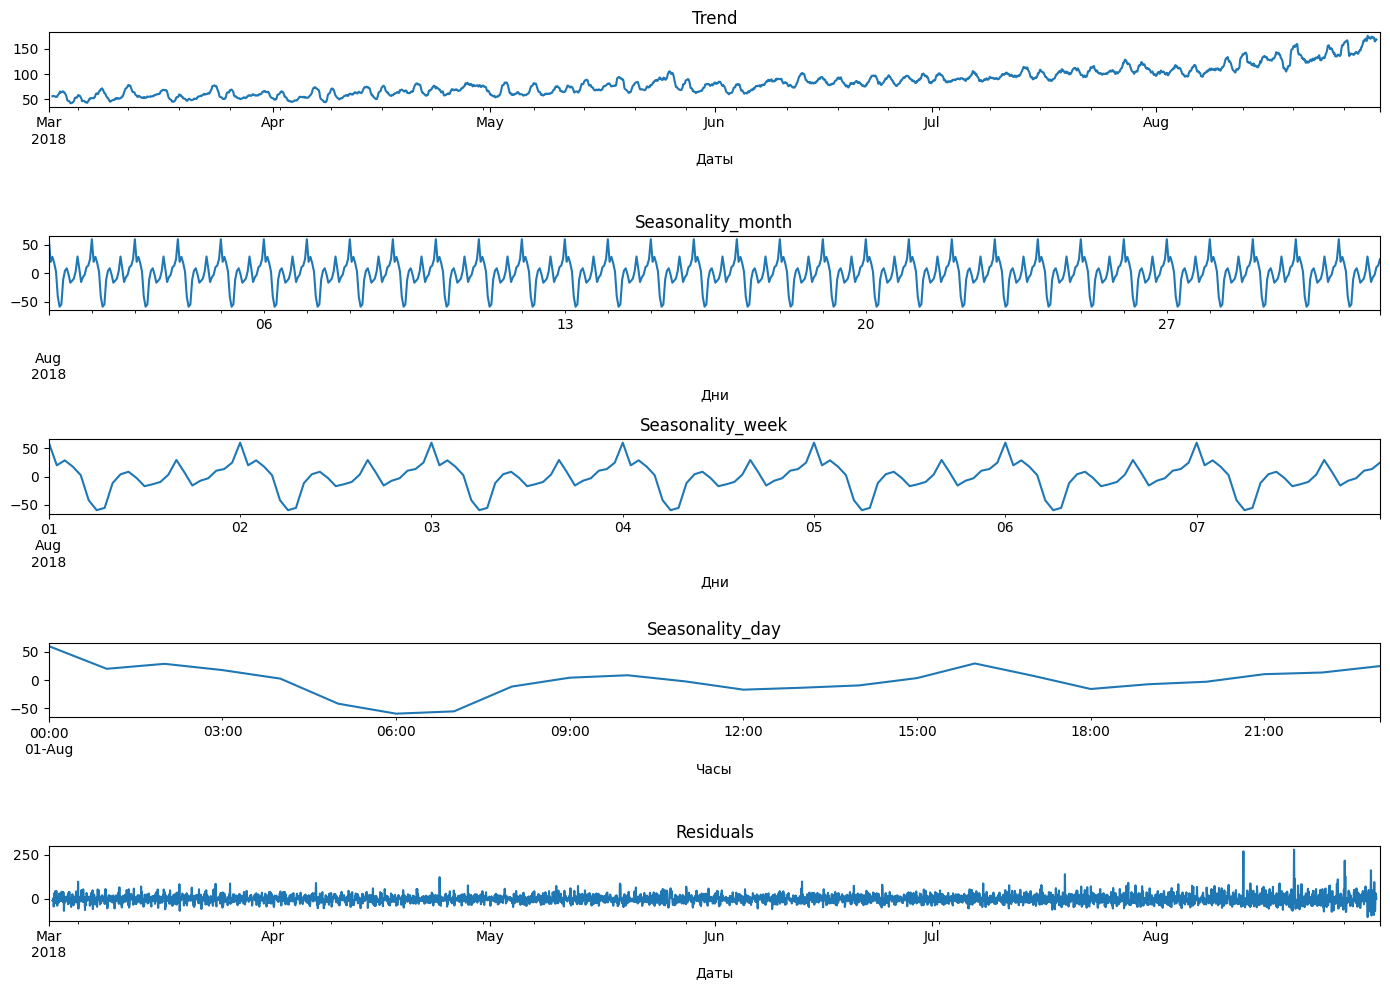

In [12]:
plt.figure(figsize=(14, 10))
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Даты')
plt.subplot(512)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca()) 
plt.title('Seasonality_month')
plt.xlabel('Дни')
plt.subplot(513)
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca()) 
plt.title('Seasonality_week')
plt.xlabel('Дни')
plt.subplot(514)
decomposed.seasonal['2018-08-01'].plot(ax=plt.gca()) 
plt.title('Seasonality_day')
plt.xlabel('Часы')
plt.subplot(515)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.xlabel('Даты')
plt.tight_layout()

Как мы и предполагали, присутствует небольшое увеличение тренда и выбросы близко к концу наблюдений. Кроме того, наблюдается цикличность в течение дня с пиком в полночь и спадом в 6 утра

## Обучение

Создадим функции для добавления новых признаков, перебора по сетке для лучшего количества добавления признаков и для подбора гиперпараметров через рандомный поиск

In [13]:
def make_features(df, max_lag, rolling_mean_size):
#Добавляем месяц, день, день недели, час, несколько отстающих значений и скользящее среднее
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

In [14]:
def best_features(max_lag=24, rolling_mean_size=20):
#Сравнивать метрику будем с максимальной в поставленной задаче. Минус из-за особенности функции cross_validate
    best_score = -48
    tscv = TimeSeriesSplit(n_splits=3)
#Подбирать будем для линейной регрессии, для других моделей пришлось бы очень долго перебирать тут же параметры
    model = LinearRegression()
#Поскольку данные цикличны в день, будем делать шаги по дням
    for lag in range(24, max_lag+1, 24):
        for roll in range(20, rolling_mean_size+1, 10):
#Каждый раз создаем датафрейм чтобы убрать изменения предыдущей итерации
            data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
            data.sort_index(inplace=True)
            data = data.resample('1H').sum()
            make_features(data, lag, roll)
            train, test = train_test_split(data, shuffle=False, test_size=0.1)
            train = train.dropna()
            X_train = train.drop(columns='num_orders')
            y_train = train['num_orders']
#Метрику находим кросс-валидацией на три фолда методом TimeSeriesSplit для временных рядов
            cv_results = cross_validate(
                model,
                X_train, 
                y_train, 
                cv=tscv, 
                scoring='neg_root_mean_squared_error'
            )
#Сравниваем метрики, сохраняем результат если лучше
            if cv_results['test_score'].mean() > best_score:
                best_score = cv_results['test_score'].mean()               
                best_lag = lag
                best_roll = roll
            del data
    print('RMSE =', best_score*-1, '|max_lag =', best_lag, '|best_roll =', best_roll)
    return  best_lag, best_roll

In [15]:
def search(estimator, params={}):
    tscv = TimeSeriesSplit(n_splits=3)
    model = estimator
    grid_search = RandomizedSearchCV(
        model, 
        params, 
        cv=tscv, 
        scoring='neg_root_mean_squared_error', 
        random_state=RANDOM_STATE, 
        n_iter=50,
        n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    print('RMSE =', best_score*-1, '|', best_model)
    return best_model

Найдём лучшее количество отстающих значений и размер окна скользящего среднего

In [16]:
best_lag, best_roll = best_features(max_lag=192, rolling_mean_size=100)

RMSE = 23.042889333838517 |max_lag = 168 |best_roll = 40


Лучше всего модель обучается на отстающих значениях за неделю и скользящем окне размером 50. Создадим эти признаки и разделим данные на тестовые и тренировочные

In [17]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
make_features(data, best_lag, best_roll)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

Подберем параметры для моделей дерева решений, бустинга LightGBM, ближайших соседей, бустинга CatBoost

In [18]:
param_tree = {
    'max_depth': range(2,20,2),
    'min_samples_leaf': range(2,20,2)
}

In [19]:
tree = search(
    DecisionTreeRegressor(random_state=RANDOM_STATE), 
    params=param_tree
)

RMSE = 26.96696830626495 | DecisionTreeRegressor(max_depth=4, min_samples_leaf=16, random_state=42)


In [20]:
params_lgbm = {'num_leaves': range(20, 41, 2), 
                  'learning_rate': np.arange(0.01, 1.0, 0.03), 
                 'n_estimators': range(100, 301, 100)}

In [21]:
lgbm = search(
    lgb.LGBMRegressor(
        random_state=RANDOM_STATE, 
        verbosity=-1
    ), 
    params=params_lgbm
)

RMSE = 23.463996857303695 | LGBMRegressor(learning_rate=0.04, n_estimators=300, num_leaves=22,
              random_state=42, verbosity=-1)


In [22]:
knn = search(
    KNeighborsRegressor(), 
    params={'n_neighbors': range(2, 20)}
)

RMSE = 27.792332730824075 | KNeighborsRegressor(n_neighbors=4)


In [23]:
cat_params = {
    'iterations': range(100, 301, 100), 
    'learning_rate': np.arange(0.01, 1, 0.03)
}

In [24]:
cat = search(
    CatBoostRegressor(
        random_state=RANDOM_STATE, 
        verbose=False), 
    params=cat_params
)

RMSE = 23.687767192959324 | <catboost.core.CatBoostRegressor object at 0x000001F15EF48070>


Кроме того, обучим модель Prophet, для которой нужна другая подготовка данных

In [25]:
data_proph = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
data_proph.sort_index(inplace=True)
data_proph = data_proph.resample('1H').sum()
data_proph = data_proph.reset_index()
data_proph.columns = ['ds', 'y']
data_proph.head(3)

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71


In [26]:
train_proph, test_proph = train_test_split(
    data_proph, shuffle=False, test_size=0.1
)

In [27]:
train_proph, val_proph = train_test_split(
    train_proph, shuffle=False, test_size=0.3
)

In [28]:
X_test_proph = test_proph.drop(columns='y')
X_val_proph = val_proph.drop(columns='y')
y_val_proph = val_proph.drop(columns='ds')

In [29]:
model_proph = Prophet(
    changepoint_range=1, 
    n_changepoints=500, 
    changepoint_prior_scale=0.1, 
    seasonality_prior_scale=30
)

In [30]:
model_proph.fit(train_proph)

19:01:15 - cmdstanpy - INFO - Chain [1] start processing
19:01:17 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
forecast = model_proph.predict(X_val_proph)
print(
    'Prophet RMSE=', 
    root_mean_squared_error(y_val_proph, forecast['yhat'])
)

Prophet RMSE= 29.831567436167578


Все модели обучены, на кросс-валидации лучше всего себя показала модель линейной регрессии. Возьмем её для дальнейшего анализа

## Тестирование

Выведем RMSE и построим график ошибок 

RMSE тестовой выборки = 34.61658839027881


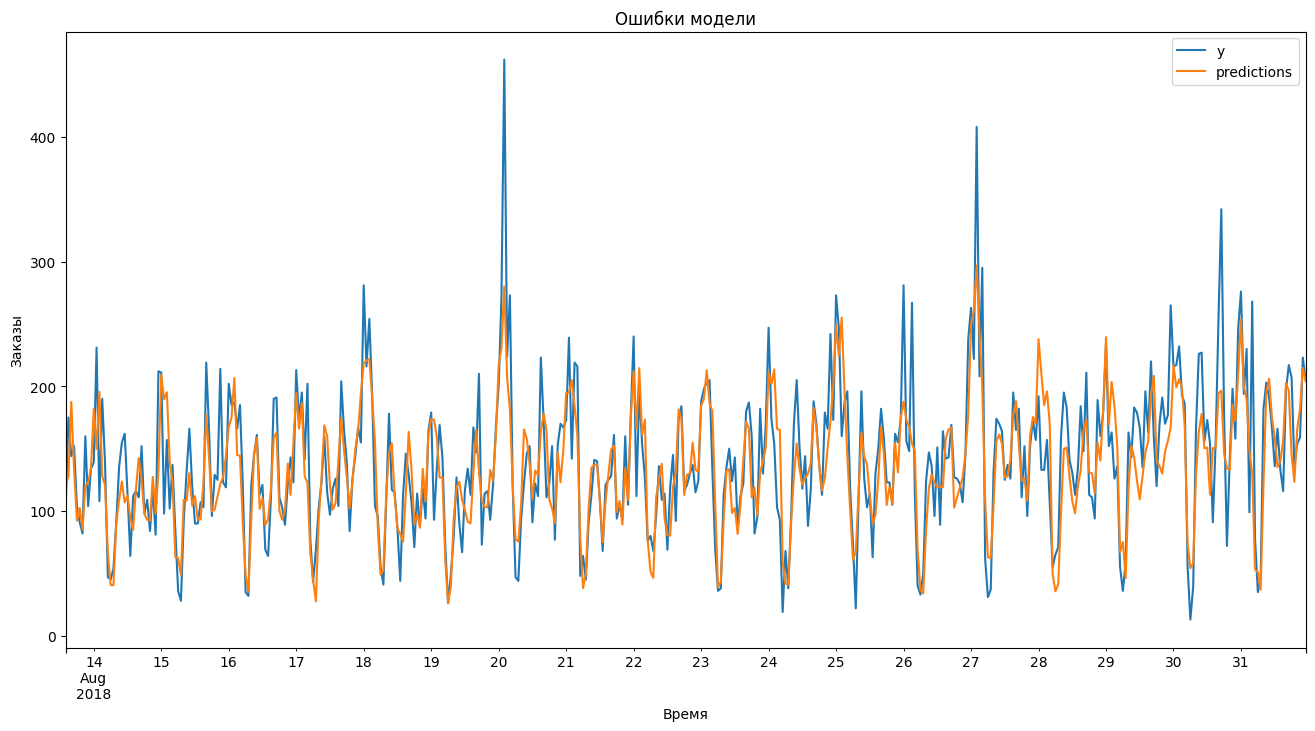

In [32]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
df = test_proph.set_index('ds', drop=True)
df['predictions'] = linreg.predict(X_test)
df.plot(
    figsize=(16,8), 
    title='Ошибки модели', 
    xlabel='Время', 
    ylabel='Заказы'
);
print(
    'RMSE тестовой выборки =', 
    root_mean_squared_error(y_test, linreg.predict(X_test))
)


In [33]:
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

KeyError: 'num_orders'

Значение RMSE с запасом удовлетворяет требованиям. Видно, что линейная регрессия хорошо уловила закономерности в изменении целевого признака. При этом видны резкие скачки и падения, которые не прогнозируются. Скорее всего, они связаны с внешними факторами. 

### Финальный вывод

* Для обучения модели предсказания заказов на следующий час были получены исторические данные о количестве заказов с привязкой ко времени в период с марта 2018 по август 2018. 
* При анализе временного ряда выяснилось, что это статический ряд, а значит он хорошо подходит для предсказаний. Кроме того, близко к концу наблюдений тренд увеличивается, присутствуют несколько выбросов. Заметна цикличность в течение суток с пиком в полночь и минимумом в 6 утра.
* Для решения задачи были выбраны несколько моделей регрессии, а именно линейная регрессия, дерево решений, метод ближайших соседей, CatBoost, LightGBM и специализированный для временных рядов Prophet. Для них в данные были добавлены новые признаки и подобраны параметры.
* По результатам обучения лучше всего себя показала **линейная регрессия**, продемонстрировав метрику RMSE примерно 34,6 и схожесть предсказанных значений с реальными.
* Для дальнейшего улучшения моделей стоит собрать подобные данные за год для возможного выявления ежегодных и сезонных закономерностей, а также составить список ежегодных праздников для учета повышенной нагрузки в эти дни.